#IMPORT

In [30]:
import sys
pythonpath = sys.executable
print(pythonpath)


D:\Anaconda3\python.exe


In [39]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [1]:
import numpy as np
# import pandas as pd
# import datetime
# from datetime import datetime
# import csv
# import os
# from os import listdir
# import json
# import scipy
# import csv
# import sys
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# from keras.layers import RNN
# from keras.utils.np_utils import to_categorical
# import keras.backend as K
# from keras import regularizers,optimizers
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import RepeatedKFold
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# from sklearn import tree
# from six import StringIO
# from IPython.display import Image
# from sklearn.tree import export_graphviz
# import pydotplus
np.random.seed(2018)

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# drive = '/content/gdrive/My Drive/PaperGiugno/'
# path_db = drive + 'db_blackblaze'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
import sys
pythonpath = sys.executable
print(pythonpath)


D:\Anaconda3\python.exe


# Functions

In [2]:
def computeDay(group):
  group = group.sort_values('date')    #ordino in base ai giorni... dal più recente al meno
  group['DayToFailure'] = list(range(group.shape[0]-1, -1,-1 ))
  return group

def divideInLevel(x):
  if x.Label == 0:
    return 'Good' #Good
  elif x.DayToFailure <= 9:
    return 'Alert' # Alert 
  elif x.DayToFailure <= 21:
    return 'Warning ' #Warning 
  else:
    return 'Very Fair'



def tolerance_acc(x):
  if x.pred == 'c_Good':
    return x.vero == 'c_Good' or x.vero == 'c_Very Fair'
  
  if x.pred == 'c_Very Fair':
    return x.vero == 'c_Good' or x.vero == 'c_Very Fair' or x.vero == 'c_Warning'
  
  if x.pred == 'c_Warning':
    return  x.vero == 'c_Very Fair' or x.vero == 'c_Warning' or x.vero == 'c_Alert' 
  
  if x.pred == 'c_Alert':
    return  x.vero == 'c_Warning' or x.vero == 'c_Alert' 


def binary_classification_pred(x):
  if x.pred == 'c_Good'  or x.pred == 'c_Very Fair':
    return 0
  else:
    return 1
    
  
def binary_classification_label(x):
  if x.vero == 'c_Good'  or x.vero == 'c_Very Fair':
    return 0
  else:
    return 1


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = data.shape[1]
  cols, names = list(), list()
  dataclass = data[data.columns[-1:]]
  data = data.drop(columns= ['serial_number', 'Class'], axis = 1)
  columns = data.columns
  # input sequence (t-n, ... t-1)  #non arrivo all'osservazione corrente
  for i in range(n_in-1, 0, -1):
    cols.append(data.shift(i))
    names += [(element + '(t-%d)' % (i)) for element in columns]
    
  for i in range(0, n_out):
    cols.append(data.shift(-i))
    if i == 0:
      names += [(element+'(t)') for element in columns]
    else:
      names += [(element +'(t+%d)' % (i)) for element in columns]
  
  cols.append(dataclass)   #appendo le ultime cinque colonne
  names += ['Class']
    
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  if dropnan:
    agg.dropna(inplace=True)
  
  return agg


def balancing_by_replication(X_train):
  
  alert = X_train[X_train.c_Alert == 1] 
  vfair = X_train[X_train['c_Very Fair'] == 1]
  warn =  X_train[X_train.c_Warning == 1]
  #'c_Alert','c_Good','c_Very Fair','c_Warning'
  good = X_train[X_train.c_Good == 1] # sono i buoni

  size_good = good.shape[0]

  while alert.shape[0] < size_good:
    app = alert.sample(min(alert.shape[0], size_good - alert.shape[0]), replace=False)
    alert = alert.append(app)

  while vfair.shape[0] < size_good:
    app = vfair.sample(min(vfair.shape[0], size_good - vfair.shape[0]), replace=False)
    vfair = vfair.append(app)
  
  while warn.shape[0] < size_good:
    app = warn.sample(min(warn.shape[0], size_good - warn.shape[0]), replace=False)
    warn = warn.append(app)

  
  good = good.append(alert)
  good = good.append(vfair)
  good = good.append(warn)
  return good 

#Pre- processing

In [3]:
listLabels = ['c_Alert','c_Good','c_Very Fair','c_Warning']
finestra = 14
# 15model\Train-WDC-WD30EFRX BalckDaUsare

df= pd.read_csv('15model\BalckDaUsare.csv',sep=';')
df = df.dropna()
df.date = pd.to_datetime(df.date, format='%Y-%m-%d').dt.date
df = df.drop(['CurrentPendingSectorCount','ReallocatedSectorsCount'], axis=1)

scaler = MinMaxScaler(feature_range = (-1,1))
df[['ReportedUncorrectableErrors', 'HighFlyWrites', 'TemperatureCelsius', 
    'RawCurrentPendingSectorCount','RawReadErrorRate', 'SpinUpTime', 
    'RawReallocatedSectorsCount', 'SeekErrorRate', 'PowerOnHours']] = scaler.fit_transform(df[['ReportedUncorrectableErrors', 
                                                                                               'HighFlyWrites', 'TemperatureCelsius', 
                                                                                               'RawCurrentPendingSectorCount',
                                                                                               'RawReadErrorRate', 'SpinUpTime', 
                                                                                               'RawReallocatedSectorsCount', 
                                                                                               'SeekErrorRate', 'PowerOnHours']])

dfHour = df.groupby(['serial_number']).apply(computeDay)
dfHour = dfHour[dfHour.DayToFailure <= 45]
dfHour = dfHour.drop(columns = ['date'])
dfHour['Class'] = dfHour.apply(divideInLevel, axis=1)
dfHour= dfHour.drop(columns= ['Label','DayToFailure', 'serial_number'], axis=1)
dfHour=dfHour.reset_index()
dfHour= dfHour.drop(columns= ['level_1'], axis=1)

In [4]:
#creo le sequenze
print('Creazione Sequenze')
dfHourSequence =  dfHour.groupby(['serial_number']).apply(series_to_supervised, n_in=finestra, n_out=1, dropnan=True)
dfHourSequence = pd.concat([dfHourSequence, pd.get_dummies(dfHourSequence.Class,prefix='c')], axis=1).drop(['Class'],axis=1)
numberClasses = len(listLabels)

#divisione in train validation e split
X_train, X_rim, y_train, y_rim = train_test_split(dfHourSequence[dfHourSequence.columns[:-numberClasses]],
                                                  dfHourSequence[dfHourSequence.columns[-numberClasses:]] ,
                                                  stratify=dfHourSequence[dfHourSequence.columns[-numberClasses:]],
                                                  test_size=0.30)

print(y_train.sum())
print(y_train.columns)
del dfHourSequence
del dfHour

Creazione Sequenze
c_Alert         1138
c_Good         63880
c_Very Fair     1077
c_Warning       1275
dtype: int64
Index(['c_Alert', 'c_Good', 'c_Very Fair', 'c_Warning '], dtype='object')


In [5]:
X_val, X_test, y_val, y_test = train_test_split(X_rim, y_rim ,stratify=y_rim, test_size=0.50)


del X_rim
del y_rim
X_train = pd.concat([X_train, pd.DataFrame(columns = listLabels)], sort = True)
X_val = pd.concat([X_val,  pd.DataFrame(columns = listLabels)], sort = True)
X_test = pd.concat([X_test, pd.DataFrame(columns = listLabels)], sort = True)

X_train[listLabels] = y_train.values
X_val[listLabels] = y_val.values
X_test[listLabels] = y_test.values


del y_train
del y_val
del y_test



print('Balancing')
Complete_train  = balancing_by_replication(X_train)
print(Complete_train.shape)
del X_train

print(X_val.groupby(listLabels).count())
Complete_val = balancing_by_replication(X_val)
print(Complete_val.shape)
del X_val

#tolgo le label
ytrain = Complete_train[listLabels].values
print(Complete_train[listLabels].sum())
Xtrain = Complete_train.drop(columns=listLabels, axis=1 )


yVal = Complete_val[listLabels].values
print(Complete_val[listLabels].sum())
Xval = Complete_val.drop(columns=listLabels, axis=1 )

yTest = X_test[listLabels].values
Xtest = X_test.drop(columns=listLabels, axis=1 )


#reshape come sequenze
Xtrain = Xtrain.values.reshape(Xtrain.shape[0], finestra, int(Xtrain.shape[1]/finestra))
Xval = Xval.values.reshape(Xval.shape[0], finestra, int(Xval.shape[1]/finestra))
Xtest= Xtest.values.reshape(Xtest.shape[0], finestra, int(Xtest.shape[1]/finestra))

print(Xtrain.shape)
print(Xval.shape)
print(Xtest.shape)

print(ytrain.shape)
print(yVal.shape)
print(yTest.shape)


Balancing
(255520, 130)
                                      HighFlyWrites(t)  HighFlyWrites(t-1)  \
c_Alert c_Good c_Very Fair c_Warning                                         
0       0      0           1                       273                 273   
               1           0                       231                 231   
        1      0           0                     13689               13689   
1       0      0           0                       244                 244   

                                      HighFlyWrites(t-10)  \
c_Alert c_Good c_Very Fair c_Warning                        
0       0      0           1                          273   
               1           0                          231   
        1      0           0                        13689   
1       0      0           0                          244   

                                      HighFlyWrites(t-11)  \
c_Alert c_Good c_Very Fair c_Warning                        
0       0      0  

#Modello

In [6]:
from keras.layers import SimpleRNN


def build_model():
  dp_lvl = 0.1
  model = Sequential()
  model.add(SimpleRNN(128, input_shape=(finestra, 9), return_sequences =  True ))
  model.add(SimpleRNN(128, return_sequences =  False))
  model.add(Dense(numberClasses, activation='softmax'))
  return model


#Addestramento

In [7]:
# import keras.optimizers
from keras.optimizer_v2.adam import Adam

epoche = 30
historyvet =[]
model = build_model()    
best_acc= 0.0
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
# adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0,amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

for epoch in range(0,epoche):
  print('Epoch {%d}' %(epoch))
  history = model.fit(Xtrain, ytrain, epochs=1, batch_size=500, validation_data= (Xval,yVal), shuffle=True)
  if (history.history['val_accuracy'][0] > best_acc ):
    print('Update best model')
    best_acc = history.history['val_accuracy'][0]
    best_epoch  = epoch
    model.save('model\RNN\Seg\{%d}best_model.h5'%(epoch))
    
  historyvet.append(history.history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 14, 128)           17664     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 51,076
Trainable params: 51,076
Non-trainable params: 0
_________________________________________________________________
Epoch {0}
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_con

#Plot

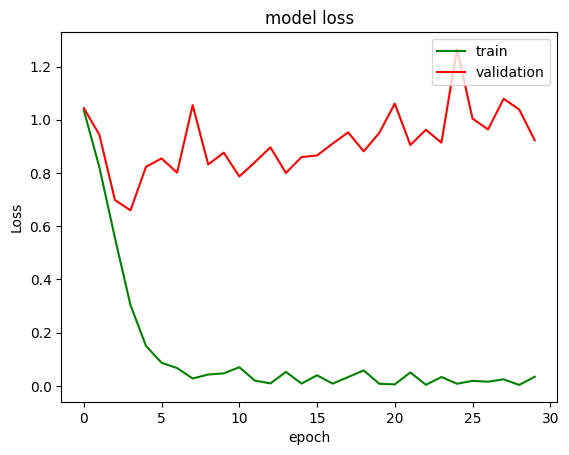

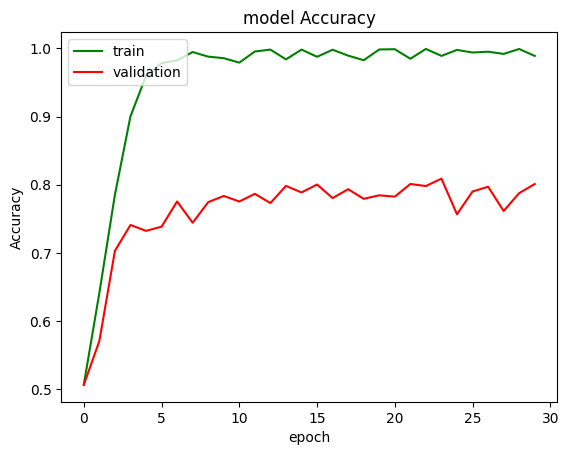

In [8]:
lossTrain=[]
lossval=[]
accTrain = []
accVal =[]

for element in historyvet:
   lossTrain.append(element['loss'][0])
   lossval.append(element['val_loss'][0])
   accTrain.append(element['accuracy'][0])
   accVal.append(element['val_accuracy'][0])
  

plt.plot(lossTrain, color='g')
plt.plot(lossval, color='r')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(accTrain, color='g')
plt.plot(accVal, color='r')
plt.title('model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Fine tuning on val

In [9]:
newModel = load_model( 'model\RNN\Seg\{23}best_model.h5')
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
newModel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
newModel.summary()
epoche = 25

historyRiadd = newModel.fit(Xval,yVal, epochs=epoche, batch_size=1024, shuffle=True)
newModel.save('model\RNN\Seg\Final_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 14, 128)           17664     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 51,076
Trainable params: 51,076
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_co

#Performance evaluation

In [10]:
print(newModel.evaluate(Xtest,yTest))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
452/452 [==============================] - 1s 2ms/step - loss: 0.1196 - accuracy: 0.9638

In [11]:
newModel = load_model( 'model\RNN\Seg\Final_model.h5')

pred = newModel.predict(Xtest)
print(pred.shape)
predpd = pd.DataFrame(pred, columns=listLabels)
print(predpd.idxmax(axis=1))
predpd= predpd.idxmax(axis=1)
predpd = predpd.to_frame()

ytestpd = pd.DataFrame(yTest, columns=listLabels)
ytestpd= ytestpd.idxmax(axis=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(14437, 4)
0             c_Good
1             c_Good
2             c_Good
3             c_Good
4             c_Good
            ...     
14432         c_Good
14433         c_Good
14434    c_Very Fair
14435         c_Good
14436         c_Good
Length: 14437, dtype: object


Accuracy sul Test : 0.9637736371822401
confusion_matrix:
[[  190     5    14    35]
 [   94 13377   104   114]
 [   22     9   171    28]
 [   46    14    38   176]]
显示百分比：
[[ 0.7787  0.0205  0.0574  0.1434]
 [ 0.0069  0.9772  0.0076  0.0083]
 [ 0.0957  0.0391  0.7435  0.1217]
 [ 0.1679  0.0511  0.1387  0.6423]]
accuracy_score: 
0.9637736371822401
precision_score: 
0.9731245037986487
recall_score: 
0.9637736371822401
f1_score: 
0.9675025221800256
FPR :  [ 0.0114  0.0374  0.0110  0.0125]
FNR :  [ 0.2213  0.0228  0.2565  0.3577]
MCC:  [ 0.6413  0.8085  0.6164  0.5565]


(array([ 0.5000,  1.5000,  2.5000,  3.5000]),
 [Text(0, 0.5, 'c_Alert'),
  Text(0, 1.5, 'c_Good'),
  Text(0, 2.5, 'c_Very Fair'),
  Text(0, 3.5, 'c_Warning')])

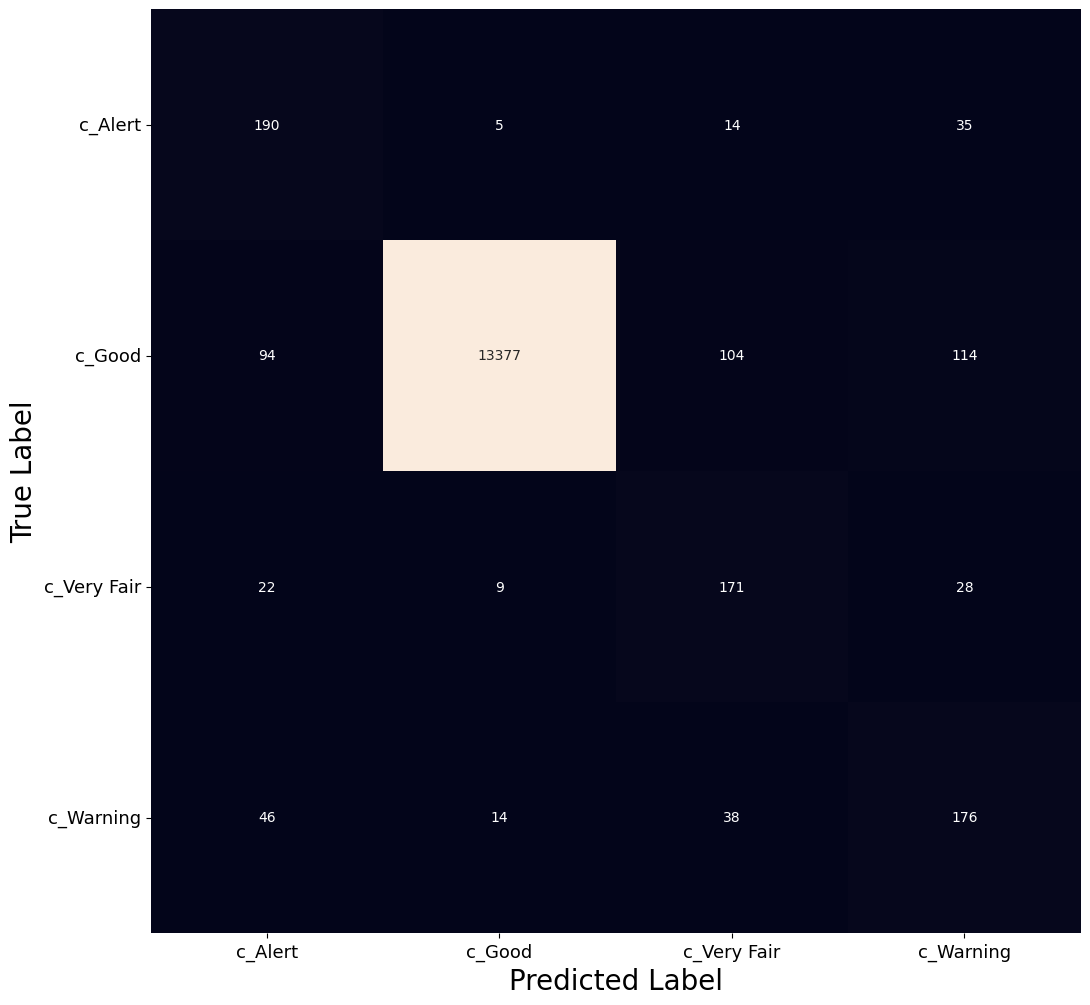

In [12]:
from sklearn import metrics

acc2 = accuracy_score(ytestpd.values, predpd.values)
print('Accuracy sul Test :', acc2)

print('confusion_matrix:')
confm = metrics.confusion_matrix(ytestpd.values, predpd.values)
print(confm)
cm = confm.astype('float') / confm.sum(axis=1)[:, np.newaxis]
print("显示百分比：")
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
print(cm)

print('accuracy_score: ')
print(metrics.accuracy_score(ytestpd.values, predpd.values))
print('precision_score: ')
print(metrics.precision_score(ytestpd.values, predpd.values, average='weighted'))
print('recall_score: ')
print(metrics.recall_score(ytestpd.values, predpd.values, average='weighted'))
print('f1_score: ')
print(metrics.f1_score(ytestpd.values, predpd.values, average='weighted'))
# TN, FP, FN, TP = confm[0,0], confm[0,1], confm[1,0], confm[1,1]
FP = confm.sum(axis=0) - np.diag(confm)
FN = confm.sum(axis=1) - np.diag(confm)
TP = np.diag(confm)
TN = confm.sum() - (FP + FN + TP)
# FP = FP.astype(float)
# FN = FN.astype(float)
# TP = TP.astype(float)
# TN = TN.astype(float)
hh = (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)

FPR = FP/(FP+TN)
# print('FPR : ',FPR)
# f1 = lambda FPR:'%.2f%%' % (100*FPR)
# for i in range(len(FPR)):
#     print(FPR[i])
# #     FPR[i] = float(FPR[i]) * 100 + '%'
# #     FPR[i] = str(FPR[i] * 100)[:5].strip()+ '%'
#     FPR[i] = "%.2f%%" % (round((FPR[i]) * 100, 3))
print('FPR : ',FPR)
print('FNR : ',FN/(FN+TP))
MCC = (TP * TN - FP * FN) / np.sqrt(hh)
print('MCC: ', MCC)

c=confusion_matrix(ytestpd.values, predpd.values)
plt.figure(figsize=(12,12))
ax = sns.heatmap(c, yticklabels=1, xticklabels=1, annot=True, fmt="d", cbar=False)
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.set_xlabel("Predicted Label",fontsize=20)
ax.set_ylabel("True Label",fontsize=20)
ax.tick_params(labelsize=13)
ax.set_xticklabels(listLabels)
ax.set_yticklabels(listLabels)
plt.yticks(rotation=0)

In [13]:
predpd = predpd.rename(columns={predpd.columns[0]:'pred'})
predpd['vero'] = ytestpd.values

buoni = predpd[predpd.vero == 'c_Good']
acc3 = accuracy_score(buoni.vero.values, buoni.pred.values)
print('Accuracy sulle sequenze good: ', acc3)

  
failed = predpd[predpd.vero != 'c_Good']
acc3 = accuracy_score(failed.vero.values, failed.pred.values)
print('Accuracy sulle sequenze failed: ', acc3) 

  
predpd['TOL']= predpd.apply(tolerance_acc, axis=1)
predpd['TOL'] = predpd['TOL'].astype(int)

buoni = predpd[predpd.vero == 'c_Good']
prest = buoni.TOL.sum()/buoni.shape[0]
print('Accuracy sulle sequenze good con tolleranza: ', prest)


failed = predpd[predpd.vero != 'c_Good']
prest = failed.TOL.sum()/failed.shape[0]
print('Accuracy sulle sequenze failed con tolleranza: ', prest)

Accuracy sulle sequenze good:  0.9772079772079773
Accuracy sulle sequenze failed:  0.7179144385026738
Accuracy sulle sequenze good con tolleranza:  0.9848053181386515
Accuracy sulle sequenze failed con tolleranza:  0.9264705882352942


In [14]:
predpd['binaryLabelPred']= predpd.apply(binary_classification_pred, axis=1)
predpd['binaryLabelTrue']= predpd.apply(binary_classification_label, axis=1)

In [15]:
x = predpd[predpd.binaryLabelTrue ==1].binaryLabelTrue.count()
y = predpd[(predpd.binaryLabelTrue ==1) & (predpd.binaryLabelPred ==1) ].binaryLabelTrue.count()

FDR = y/x
print('FDR ', FDR)

x = predpd[predpd.binaryLabelTrue ==0].binaryLabelTrue.count()
y = predpd[(predpd.binaryLabelTrue ==0) & (predpd.binaryLabelPred ==1) ].binaryLabelTrue.count()

FAR = y/x
print('FAR ', FAR)

FDR  0.862934362934363
FAR  0.01853581435447949
